In [36]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim

import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np

from PIL import Image
import cv2
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import time
from tensorboard import Tensorboard
from constant import *

# Test if this imporve runtime (People claim that this improve runtime if input size is the same)
# import torch.backend.cudnn as cudnn
# cudnn.benchmark=True

from models.densenet import DenseNet
from models.resnet import Resnet
from models.inception import InceptionNet

### CAM

In [106]:
def plot_cam_results(crt_blended_image, crt_cam_image, crt_xray_image, map_caption):
    import matplotlib.pyplot as plt

    fig = plt.figure(figsize = (15,7))

    ax1 = fig.add_subplot(2, 3, 1)
    ax1.imshow(crt_xray_image, cmap = 'gray', interpolation = 'bicubic')
    ax1.set_title('Orig X Ray')
    plt.axis('off')

    ax2 = fig.add_subplot(2,3, 2)
    cam_plot = ax2.imshow(crt_cam_image, cmap=plt.get_cmap('OrRd'), interpolation = 'bicubic')
    plt.colorbar(cam_plot, ax=ax2)
    ax2.set_title('Activation Map')
    plt.axis('off')

    ax3 = fig.add_subplot(2,3, 3)
    blended_plot = ax3.imshow(crt_blended_image, interpolation = 'bicubic')
    plt.colorbar(cam_plot, ax=ax3)
    ax3.set_title(map_caption)
    plt.axis('off')
    plt.show()

In [37]:
net = DenseNet('densenet161').cuda()
model_name = '%s/densenet/densenet161/%s/model.path.tar' % (MODEL_DIR, '20180501-132749')
checkpoint = torch.load(model_name)
net.load_state_dict(checkpoint['state_dict'])
net.eval();

In [38]:
def returnCAM(feature_conv, weight_softmax, disease_index):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    print('Featrure', feature_conv.shape)
    print('Weight', weight_softmax.shape)

    cam = weight_softmax[disease_index].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    cam_img = np.uint8(255 * cam_img)
    cam_img = cv2.resize(cam_img, size_upsample)
    return cam_img

In [68]:
def normalize_nd_array(crt_array):
    # Normalised [0,1]
    crt_array = crt_array - np.min(crt_array)
    normalized = crt_array/np.ptp(crt_array)
    return normalized

In [63]:
def process_cam_image(crt_cam_image, xray_image, crt_alpha = .5):
    im_width, im_height, _ = xray_image.shape
    crt_cam_image = cv2.resize(crt_cam_image, (im_width, im_height), \
                               interpolation=cv2.INTER_CUBIC)
    
#     do some gamma enhancement, e is too much
    crt_cam_image = np.power(1.1, crt_cam_image)
    crt_cam_image = normalize_nd_array(crt_cam_image)
    # crt_cam_image[np.where(crt_cam_image < 0.5)] = 0 
    crt_cam_image = 255*crt_cam_image

    # make cam an rgb image
    empty_image_channel = np.zeros(dtype = np.float32, shape = crt_cam_image.shape[:2])
    crt_cam_image = cv2.merge((crt_cam_image,empty_image_channel,empty_image_channel))
    
    blended_image = cv2.addWeighted(xray_image.astype('uint8'),crt_alpha,\
                                    crt_cam_image.astype('uint8'),(1-crt_alpha),0)
    return blended_image

In [39]:
normalize = transforms.Normalize(net.mean, net.std)
transformList = []
transformList.append(transforms.Resize(net.input_size))
transformList.append(transforms.ToTensor())
transformList.append(normalize)   
transform = transforms.Compose(transformList)

Featrure (1, 2208, 7, 7)
Weight (14, 2208)


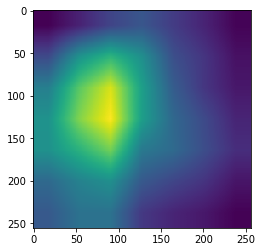

In [101]:
image_file = '/home/dattran/data/xray/00000013_002.png'
image = Image.open(image_file).convert('RGB')
image = transform(image)
image = image.unsqueeze_(0)
input = Variable(image).cuda()
feature = net.extract(input).cpu().data.numpy()
weights = list(net.classifier.parameters())[0].cpu().data.numpy()

prediction = net(input).cpu().data.numpy().squeeze()
disease_index = np.argmax(prediction)
disease = CLASS_NAMES[disease_index]
# print('Feature', feature.shape)
# print('Weight', weights.shape)
cam = returnCAM(feature, weights, [disease_index])
plt.figure()
plt.imshow(cam);

image = cv2.imread(image_file)

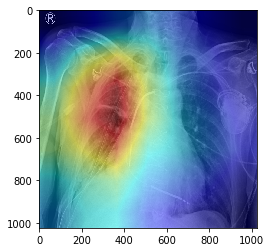

In [104]:
height, width, _ = image.shape
heatmap = cv2.applyColorMap(cv2.resize(cam, (width, height)), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_RGB2BGR)
result = heatmap * 0.3 + image * 0.5
cv2.imwrite('cam-heatmap_before.jpg', result)
result = normalize_nd_array(result)
plt.imshow(result)

In [82]:
cv2.imwrite('xray_cam.jpg', cam)

True

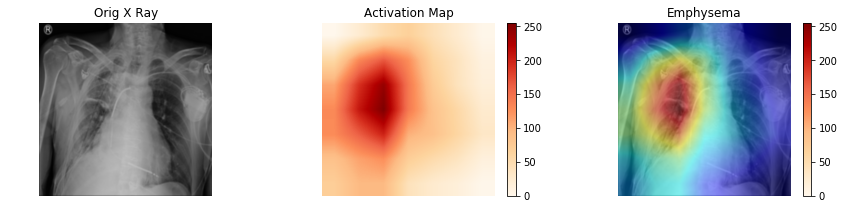

In [107]:
plot_cam_results(result, cam, image, disease)